## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import json
from tqdm.auto import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

## Load model

In [10]:
%run ../models/checkpoint/__init__.py

In [12]:
# run_name = '1215_174443_cxr14_resnet-50-v2_lr0.0001_os_Cardiomegaly_normS_size256_sch-roc_auc-p5-f0.1'
run_name = '1203_223059_cxr14_densenet-121-v2_lr0.0001_aug_normS_size256_sch-roc_auc-p5-f0.1'
debug_run = False

In [13]:
compiled_model = load_compiled_model_classification(run_name, debug=debug_run)
compiled_model.metadata['model_kwargs']

{'model_name': 'densenet-121-v2',
 'labels': ['Atelectasis',
  'Cardiomegaly',
  'Effusion',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pneumonia',
  'Pneumothorax',
  'Consolidation',
  'Edema',
  'Emphysema',
  'Fibrosis',
  'Pleural_Thickening',
  'Hernia'],
 'imagenet': True,
 'freeze': False,
 'gpool': 'avg',
 'fc_layers': []}

In [18]:
_ = compiled_model.model.eval()

## Load data

In [14]:
%run ../datasets/__init__.py

In [15]:
dataset_kwargs = {
    'dataset_name': 'cxr14',
    'dataset_type': 'test-bbox',
    'max_samples': None,
    'image_size': (1024, 1024),
    'norm_by_sample': True,
}
dataloader = prepare_data_classification(**dataset_kwargs)
dataset = dataloader.dataset
len(dataset)

880

## Dive params

In [4]:
data_folder = os.path.join('..', '..', 'data')
ATLAS_FPATH = os.path.join(data_folder, 'test-bbox-atlas.png')
RECORDS_FPATH = os.path.join(data_folder, 'records.json')

In [5]:
target_h = 50
target_w = 50

## Prepare data for facets dive

### Create JSON file

In [6]:
import json
from torch import sigmoid

In [17]:
device = 'cuda'

In [30]:
records = []

for item in tqdm(dataloader.dataset):
    record = {
        'fname': item.image_fname,
    }
    
    with torch.no_grad():
        images = item.image.unsqueeze(0).to(device)
        outputs = compiled_model.model(images)
        preds = outputs[0].cpu().squeeze(0)
        preds = sigmoid(preds)
    
    for label_value, pred, label_name in zip(
        item.labels,
        preds,
        dataloader.dataset.labels,
    ):
        record[label_name] = int(label_value)
        # int to avoid int64 not-serializable errors
        
        record[f'{label_name}-pred'] = pred.item()
    
    records.append(record)
    
len(records)

880

In [32]:
with open(RECORDS_FPATH, 'w') as f:
    json.dump(records, f)

In [9]:
json_records = json.dumps(records)
# json_records

### Create atlas image

In [10]:
import os
from torch.nn.functional import interpolate
from PIL import Image

In [11]:
%run ../utils/common.py

In [12]:
n_images = len(dataloader.dataset)
n_channels = 3

def resize_image(image):
    image = interpolate(image.unsqueeze(0), (target_h, target_w), mode='nearest')
    return image.squeeze(0)

n_cols = int(np.ceil(np.sqrt(n_images)))
n_rows = int(np.ceil(n_images / n_cols))
atlas = torch.zeros(n_channels, target_h * n_rows, target_w * n_cols)

for index, item in enumerate(dataloader.dataset):
    image = tensor_to_range01(item.image)
    resized_image = resize_image(image)
    
    row_from = (index // n_cols) * target_h
    row_to = row_from + target_h
    col_from = (index % n_cols) * target_w
    col_to = col_from + target_w
    
    atlas[:, row_from:row_to, col_from:col_to] = resized_image

In [14]:
atlas_np = (atlas.permute(1, 2, 0) * 255).type(torch.uint8).numpy()
atlas_pil = Image.fromarray(atlas_np, mode='RGB')
atlas_pil.save(ATLAS_FPATH)

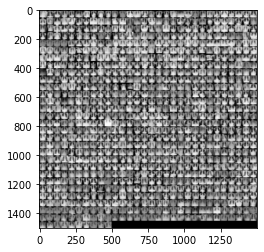

In [15]:
plt.imshow(atlas_pil)

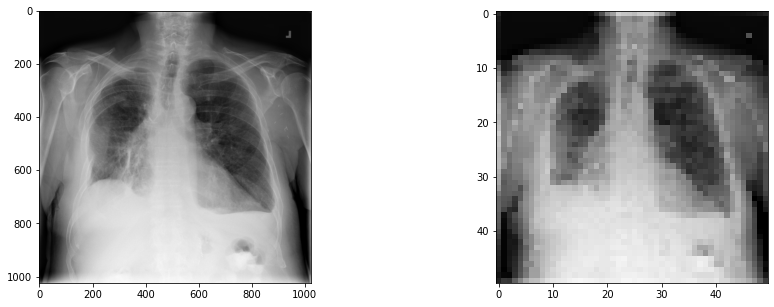

In [67]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))

plt.subplot(1, 2, 2)
plt.imshow(resized_image.permute(1, 2, 0))

## Run Facets Dive!

In [6]:
from IPython.core.display import display, HTML
import json

In [7]:
with open(RECORDS_FPATH, 'r') as f:
    json_records = json.load(f)

In [25]:
%%html
<style>
facets-dive-info-card {
    height: 600px;
}
</style>

In [23]:
HTML_TEMPLATE = """
    <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js">
    </script>
    <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
    <facets-dive
        sprite-image-width="{sprite_w}"
        sprite-image-height="{sprite_h}"
        id="elem"
        height="600"
        atlas-url="{atlas_fpath}"
        >
    </facets-dive>
    <script>
      document.querySelector("#elem").data = {jsonstr};
    </script>
"""

# Load the json dataset and the sprite_size into the template
html = HTML_TEMPLATE.format(jsonstr=json_records,
                            sprite_h=target_h,
                            sprite_w=target_w,
                            atlas_fpath=ATLAS_FPATH,
                           )

# Display the template
display(HTML(html))